In [1]:
import sys
sys.path.append('..')

In [ ]:
from aequilibrae.utils.create_example import create_example

In [2]:
import logging
import sys
from aequilibrae import Project
from aequilibrae.paths import TrafficAssignment, TrafficClass
from aequilibrae import logger

In [3]:
stdout_handler = logging.StreamHandler(sys.stdout)
formatter = logging.Formatter("%(asctime)s ; %(levelname)s ; %(message)s")
stdout_handler.setFormatter(formatter)
logger.addHandler(stdout_handler)

In [4]:
pth = 'D:/release/Sample models/Birmingham'

In [5]:
proj = Project()
proj.open(pth)

2021-03-03 17:02:16,272 ; INFO ; Opened project on D:/release/Sample models/Birmingham


In [6]:
proj_matrices = proj.matrices
proj_matrices.update_database()
mat_list = proj_matrices.list()

In [7]:
mat_list

,name,file_name,cores,procedure,procedure_id,timestamp,description,status
0,demand_omx,demand.omx,3,None,None,2021-02-21 08:42:05,None,


In [8]:
proj.network.build_graphs()
carGraph = proj.network.graphs['c']
truckGraph = proj.network.graphs['T']
motoGraph = proj.network.graphs['M']

for graph in [motoGraph, carGraph, motoGraph]:
    graph.graph.loc[:, 'free_flow_time'] *= 60
    graph.graph.loc[graph.graph.free_flow_time==0, 'free_flow_time'] = 0.0001

2021-03-03 17:02:16,756 ; WARNING ; Field(s) name has(ve) at least one NaN value. Check your computations
2021-03-03 17:02:16,987 ; WARNING ; Field(s) name has(ve) at least one NaN value. Check your computations
2021-03-03 17:02:17,212 ; WARNING ; Field(s) name has(ve) at least one NaN value. Check your computations
2021-03-03 17:02:17,344 ; WARNING ; Field(s) name has(ve) at least one NaN value. Check your computations
2021-03-03 17:02:17,570 ; WARNING ; Field(s) name has(ve) at least one NaN value. Check your computations
2021-03-03 17:02:17,697 ; WARNING ; Field(s) name has(ve) at least one NaN value. Check your computations


In [10]:
carDemand = proj_matrices.get_matrix('demand_omx')
carDemand.computational_view('car')
carClass = TrafficClass(carGraph, carDemand)
carClass.set_pce(1)
carClass.set_vot(35)
carClass.set_fixed_cost('toll', 0.025)

In [11]:
motoDemand = proj_matrices.get_matrix('demand_omx')
motoDemand.computational_view('motorcycle')
motoClass = TrafficClass(motoGraph, motoDemand)
motoClass.set_pce(0.2)
motoClass.set_vot(35)
motoClass.set_fixed_cost('toll', 0.0125)

In [12]:
truckDemand = proj_matrices.get_matrix('demand_omx')
truckDemand.computational_view('trucks')
truckClass = TrafficClass(truckGraph, truckDemand)
truckClass.set_pce(1.5)
truckClass.set_vot(35)
truckClass.set_fixed_cost('toll', 0.05)

In [14]:
assig = TrafficAssignment()
assig.set_classes([carClass, motoClass, truckClass])

assig.set_vdf("BPR")  # This is not case-sensitive # Then we set the volume delay function

assig.set_vdf_parameters({"alpha": "alpha", "beta": "beta"})  # And its parameters

assig.set_time_field("free_flow_time")
assig.set_capacity_field(f"capacity")  # The capacity and free flow travel times as they exist in the graph

# And the algorithm we want to use to assign
assig.set_algorithm('bfw')

# since I haven't checked the parameters file, let's make sure convergence criteria is good
assig.max_iter = 1000
assig.rgap_target = 0.0000001

assig.execute()  # we then execute the assignment

2021-03-03 17:44:55,609 ; INFO ; bfw Assignment STATS
2021-03-03 17:44:55,609 ; INFO ; Iteration, RelativeGap, stepsize
2021-03-03 17:44:58,264 ; INFO ; 1,inf,1.0
2021-03-03 17:45:00,897 ; INFO ; 2,0.6913445668215419,0.2468926882545767
2021-03-03 17:45:03,568 ; INFO ; 3,0.5584183823998772,0.0
2021-03-03 17:45:06,604 ; INFO ; 4,0.48011290781966537,0.2697263558667902
2021-03-03 17:45:09,674 ; INFO ; 5,0.3030464445556761,0.28488582406840285
2021-03-03 17:45:12,743 ; INFO ; 6,0.18643727485037184,0.3464000533789368
2021-03-03 17:45:15,974 ; INFO ; 7,0.1449633750000223,0.40734084474954185
2021-03-03 17:45:19,055 ; INFO ; 8,0.12110889401168684,0.6135653301533219
2021-03-03 17:45:22,215 ; INFO ; 9,0.11140992378031124,0.15349479185105122
2021-03-03 17:45:25,157 ; INFO ; 10,0.08259464531050748,0.03974176113752387
2021-03-03 17:45:28,286 ; INFO ; 11,0.07563686509473645,0.16049037460208834
2021-03-03 17:45:31,343 ; INFO ; 12,0.057755357035169534,0.2955969855794807
2021-03-03 17:45:34,306 ; INFO ; 

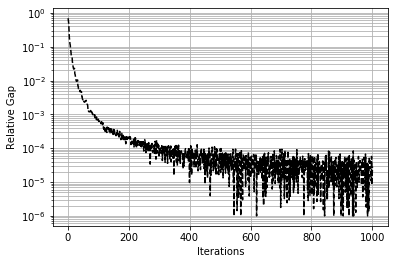

In [17]:
import matplotlib.pyplot as plt

df = assig.report()

df.loc[df.rgap<0.000001, 'rgap']=0.000001
x = df.iteration.values
y = df.rgap.values


fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(x, y, "k--")
plt.yscale("log")
plt.grid(True, which="both")
plt.xlabel(r"Iterations")
plt.ylabel(r"Relative Gap")
plt.show()